In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
import torch.optim as optim 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # colormaps
%matplotlib inline
from torch.autograd import Variable

#importing Fashion Mnist dataset
transform_list = transforms.Compose([ transforms.ToTensor(), transforms.Normalize(mean=[0.0], std=[1.0,]) ] )
mnist_trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_list)
mnist_testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_list)

X_train = mnist_trainset.data.numpy()
y_train = mnist_trainset.targets.numpy()
X_test = mnist_testset.data.numpy()
y_test = mnist_testset.targets.numpy()

#smaller dataset to test proof of concept
X_train = X_train[:60000,:,:]
y_train = y_train[:60000]
X_test = X_test[:10000,:,:]
y_test = y_test[:10000]

print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)


(60000,)
(60000, 28, 28)
(10000,)
(10000, 28, 28)


In [2]:
def neural_network_with_CCP(X_train,X_test,y_train,y_test,input_dim,hidden_layer,output_layer,learning_rate,epochs,kf):
    X_train_nn = Variable(torch.from_numpy(X_train)).float()
    y_train_nn = Variable(torch.from_numpy(y_train)).long()
    X_test_nn  = Variable(torch.from_numpy(X_test)).float()
    y_test_nn  = Variable(torch.from_numpy(y_test)).long()
    
    class N_Net( nn.Module ):    
        def __init__(self):
            super(N_Net, self).__init__()
            self.layers = nn.Sequential( 
                nn.Flatten(), 
                nn.Linear(input_dim,hidden_layer[0]),
                nn.ReLU(),
                nn.Linear(hidden_layer[0], hidden_layer[1]), 
                nn.ReLU(),
                nn.Linear(hidden_layer[1], output_layer),
                nn.LogSoftmax(dim=1))
        
        def forward(self, x):
            x1 = self.layers(x)
            return x1       
    n_Net = N_Net()
    
    #cross conformal prediction for Neural Network
    def ccp(X_train,X_test,y_train,kf):
        rank_of_folds = None
        for rest_i, fold_i in kf.split(X_train):
            X_rest, X_fold = X_train[rest_i], X_train[fold_i]
            y_rest, y_fold = y_train[rest_i], y_train[fold_i] 
            c_score_fold = n_Net(X_fold).numpy()
            c_score_one = n_Net(X_test).numpy()
            rank_fold = None
            for each in c_score_one:
                rank = np.sum(c_score_fold<each,0)+1
                if rank_fold is None:
                    rank_fold = [rank-1]
                else:
                    rank_fold = np.vstack((rank_fold,[rank-1]))
            if rank_of_folds is None:
                rank_of_folds = [rank_fold]
            else:
                rank_of_folds = np.vstack((rank_of_folds, [rank_fold]))
        sum_ranks = np.sum(rank_of_folds,0)
        p_values = (sum_ranks+1)/len(y_train)
        return(p_values)   

    loss_train = np.zeros((epochs,))
    loss_test = np.zeros((epochs,))
    accuracy_test_CCP_True = np.zeros((epochs,))
    accuracy_test_NN_True = np.zeros((epochs,))
    optimizer1 = optim.RMSprop( n_Net.parameters(), lr=learning_rate )
    loss_function = nn.CrossEntropyLoss() 
    true_test_label = y_test_nn.numpy()
    error_train = 0

    for epoch in range(epochs):
        total_train = 0
        error_train = 0
        optimizer1.zero_grad()
        y_pred_train_NN = n_Net(X_train_nn)
        loss_NN = loss_function(y_pred_train_NN, y_train_nn)
        total_train += y_train_nn.size(0)
        loss_t = loss_NN.item()
        loss_train[epoch] = 100 * loss_t / total_train
        loss_NN.backward()
        optimizer1.step()     
        correct_NN = 0 
        correct_CPP = 0 
        total = 0 
        error_test = 0
        cnn_accuracy = 0
        ccp_accuracy = 0
        
        with torch.no_grad():
            y_pred_NN = n_Net(X_test_nn).numpy()
            y_p_values_CCP = ccp(X_train_nn,X_test_nn,y_train_nn,kf)
            y_hat_CCP = np.argmax(y_p_values_CCP,axis=1)
            y_pred_NN_loss = n_Net(X_test_nn)
            loss_test_CNN = loss_function(y_pred_NN_loss, y_test_nn)
            error_test = loss_test_CNN.item()
            y_predicted_NN = np.argmax(y_pred_NN,axis = 1)
            correct_NN = np.mean(y_predicted_NN==true_test_label)
            correct_CPP = np.mean(y_hat_CCP==true_test_label)
            total += y_test_nn.size(0)
        accuracy_test_NN_True[epoch] = correct_NN
        accuracy_test_CCP_True[epoch] = correct_CPP
        loss_test[epoch] = 100 * error_test / total
           
    return loss_train,loss_test,accuracy_test_NN_True,accuracy_test_CCP_True

Insert the Hyper parameters here

In [3]:
#Hyper parameters
from sklearn.model_selection import KFold 
ran_state = 301
kf = KFold(shuffle=True, random_state=ran_state) 
input_dim = 28*28
hidden_layer = [300,200]
output_layer = 10
learning_rate = 0.0001

epochs = 50


loss_train = np.zeros((epochs,))
loss_test = np.zeros((epochs,))
accuracy_test_NN_True = np.zeros((epochs,))
accuracy_test_CCP_True = np.zeros((epochs,))

loss_train, loss_test, accuracy_test_NN_True, accuracy_test_CCP_True = neural_network_with_CCP(X_train,X_test,y_train,y_test,
                                                                       input_dim,hidden_layer,output_layer,learning_rate,epochs,kf)

In [4]:
print("Training Loss of the model: ",loss_train[-1])  
print("Testing Loss of the model: ",loss_test[-1]) 
print("Accuracy of the model between True Label and NN: ",accuracy_test_NN_True[-1])
print("Accuracy of the model between True Label and CCP: ",accuracy_test_CCP_True[-1])

Training Loss of the model:  0.0012633819381395975
Testing Loss of the model:  0.008632943630218506
Accuracy of the model between True Label and NN:  0.7526
Accuracy of the model between True Label and CCP:  0.7667


Implementing Regularisation with Dropout

In [5]:
def regularised_NN_CCP_model(X_train,X_test,y_train,y_test,input_dim,hidden_layer,output_layer,learning_rate,epochs,kf):
    X_train_nn = Variable(torch.from_numpy(X_train)).float()
    y_train_nn = Variable(torch.from_numpy(y_train)).long()
    X_test_nn  = Variable(torch.from_numpy(X_test)).float()
    y_test_nn  = Variable(torch.from_numpy(y_test)).long()
    
    class N_Net( nn.Module ):    
        def __init__(self):
            super(N_Net, self).__init__()
            self.layers = nn.Sequential( 
                nn.Flatten(), 
                nn.Linear(input_dim,hidden_layer[0]),
                nn.Dropout(0.5),
                nn.ReLU(),
                nn.Linear(hidden_layer[0], hidden_layer[1]), 
                nn.Dropout(0.25),
                nn.ReLU(),
                nn.Linear(hidden_layer[1], output_layer),
                nn.LogSoftmax(dim=1))
        
        def forward(self, x):
            x1 = self.layers(x)
            return x1
        
    n_Net = N_Net()
    
    #cross conformal prediction for Neural Network
    def ccp(X_train,X_test,y_train,kf):
        rank_of_folds = None
        for rest_i, fold_i in kf.split(X_train):
            X_rest, X_fold = X_train[rest_i], X_train[fold_i]
            y_rest, y_fold = y_train[rest_i], y_train[fold_i] 
            c_score_fold = n_Net(X_fold).numpy()
            c_score_one = n_Net(X_test).numpy()
            rank_fold = None
            for each in c_score_one:
                rank = np.sum(c_score_fold<each,0)+1
                if rank_fold is None:
                    rank_fold = [rank-1]
                else:
                    rank_fold = np.vstack((rank_fold,[rank-1]))
            if rank_of_folds is None:
                rank_of_folds = [rank_fold]
            else:
                rank_of_folds = np.vstack((rank_of_folds, [rank_fold]))
        sum_ranks = np.sum(rank_of_folds,0)
        p_values = (sum_ranks+1)/len(y_train)
        return(p_values)   

    loss_train = np.zeros((epochs,))
    loss_test = np.zeros((epochs,))

    accuracy_test_CCP_True = np.zeros((epochs,))
    accuracy_test_NN_True = np.zeros((epochs,))

    optimizer1 = optim.RMSprop( n_Net.parameters(), lr=learning_rate )
    loss_function = nn.CrossEntropyLoss() 
    true_test_label = y_test_nn.numpy()
    error_train = 0

    for epoch in range(epochs):
        total_train = 0
        error_train = 0
        optimizer1.zero_grad()
        y_pred_train_NN = n_Net(X_train_nn)
        loss_NN = loss_function(y_pred_train_NN, y_train_nn)
        
        total_train += y_train_nn.size(0)
        loss_t = loss_NN.item()
        loss_train[epoch] = 100 * loss_t / total_train
        loss_NN.backward()
        optimizer1.step()
              
        correct_NN = 0 
        correct_CPP = 0 
        total = 0 
        error_test = 0
        cnn_accuracy = 0
        ccp_accuracy = 0
        
        with torch.no_grad():
            y_pred_NN = n_Net(X_test_nn).numpy()
            y_p_values_CCP = ccp(X_train_nn,X_test_nn,y_train_nn,kf)
            y_hat_CCP = np.argmax(y_p_values_CCP,axis=1)
            y_pred_NN_loss = n_Net(X_test_nn)
            loss_test_CNN = loss_function(y_pred_NN_loss, y_test_nn)
            #loss_test[epoch] = loss_test_CNN.item() 
            error_test = loss_test_CNN.item()
            y_predicted_NN = np.argmax(y_pred_NN,axis = 1)
            correct_NN = np.mean(y_predicted_NN==true_test_label)
            correct_CPP = np.mean(y_hat_CCP==true_test_label)
            total += y_test_nn.size(0)
            
        accuracy_test_NN_True[epoch] = correct_NN
        accuracy_test_CCP_True[epoch] = correct_CPP
        loss_test[epoch] = 100 * error_test / total
           
    return loss_train,loss_test,accuracy_test_NN_True,accuracy_test_CCP_True

In [6]:
#Hyper parameters
from sklearn.model_selection import KFold 
ran_state = 301
kf = KFold(shuffle=True, random_state=ran_state) 
input_dim = 28*28
hidden_layer = [300,200]
output_layer = 10
learning_rate = 0.0001

loss_train_d = np.zeros((epochs,))
loss_test_d = np.zeros((epochs,))
accuracy_test_NN_d = np.zeros((epochs,))
accuracy_test_CCP_d = np.zeros((epochs,))

loss_train_d, loss_test_d, accuracy_test_NN_d, accuracy_test_CCP_d = regularised_NN_CCP_model(X_train,X_test,y_train,y_test,
                                                                     input_dim,hidden_layer,output_layer,learning_rate,epochs,kf)

In [7]:
print("Training Loss of the model: ",loss_train_d[-1])  
print("Testing Loss of the model: ",loss_test_d[-1]) 
print("Accuracy of the model between True Label and NN: ",accuracy_test_NN_d[-1])
print("Accuracy of the model between True Label and CCP: ",accuracy_test_CCP_d[-1])

Training Loss of the model:  0.0017725950479507446
Testing Loss of the model:  0.011107801198959351
Accuracy of the model between True Label and NN:  0.6816
Accuracy of the model between True Label and CCP:  0.7655


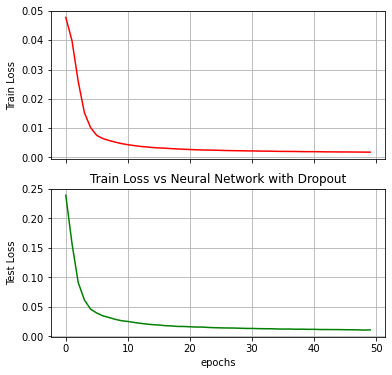

In [8]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(6, 6), sharex=True)
ax1.plot(loss_train_d, color = 'r')
ax1.set_ylabel("Train Loss")
ax2.plot(loss_test_d, color = 'g')
ax1.grid()
ax2.set_ylabel("Test Loss")
ax2.set_xlabel("epochs");
plt.title('Train Loss vs Neural Network with Dropout')
ax2.grid()

Text(0.5, 1.0, 'Test Loss vs Test Accuracy with Dropout')

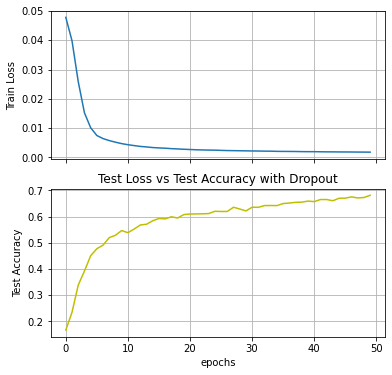

In [9]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(6 , 6), sharex=True)
ax1.plot(loss_train_d)
ax1.set_ylabel("Train Loss")
ax1.grid()
ax2.plot(accuracy_test_NN_d, color = 'y')
ax2.set_ylabel("Test Accuracy")
ax2.set_xlabel("epochs")
ax2.grid()
plt.title('Test Loss vs Test Accuracy with Dropout')

Text(0.5, 1.0, 'Test Loss vs Accuracy of Cross Conformal Prediction with Dropout')

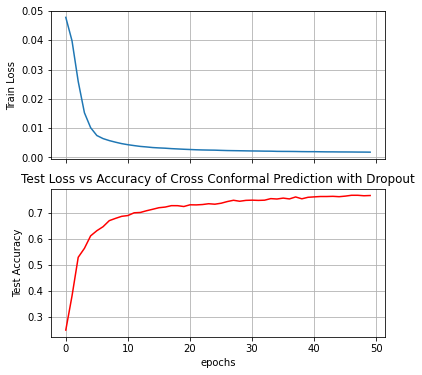

In [10]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(6, 6), sharex=True)

ax1.plot(loss_train_d)
ax1.set_ylabel("Train Loss")
ax1.grid()
ax2.plot(accuracy_test_CCP_d, color = 'r')
ax2.set_ylabel("Test Accuracy")
ax2.set_xlabel("epochs")
ax2.grid()
plt.title('Test Loss vs Accuracy of Cross Conformal Prediction with Dropout')

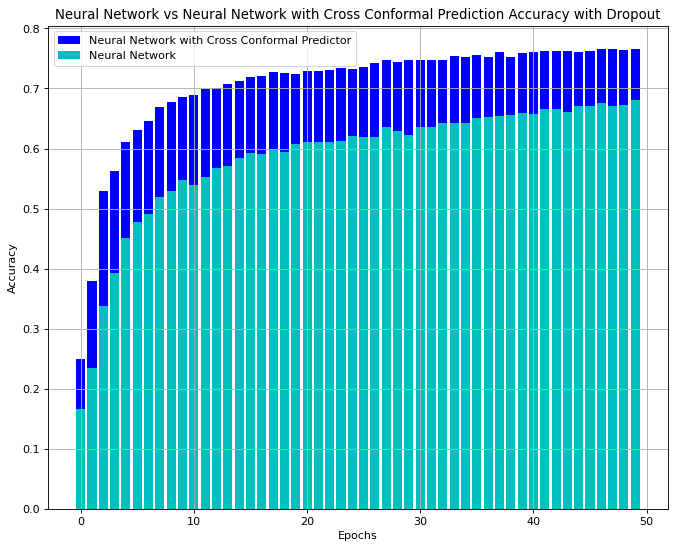

In [11]:
from matplotlib.pyplot import figure
figure(figsize=(10, 8), dpi=80)

epoch_no = list(range(0, epochs))
plt.bar(epoch_no, accuracy_test_CCP_d, color = 'b')
plt.bar(epoch_no, accuracy_test_NN_d, color = 'c')
plt.title('Neural Network vs Neural Network with Cross Conformal Prediction Accuracy with Dropout')
plt.legend(('Neural Network with Cross Conformal Predictor','Neural Network'))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()



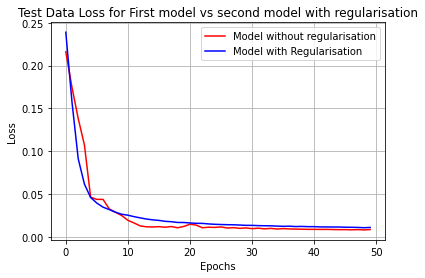

In [12]:
epoch_no = list(range(0, epochs))
plt.plot(epoch_no, loss_test, color='r')
plt.plot(epoch_no, loss_test_d, color='b')
plt.title('Test Data Loss for First model vs second model with regularisation')
plt.legend(('Model without regularisation','Model with Regularisation'))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()

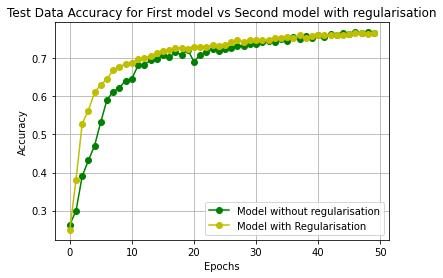

In [13]:
epoch_no = list(range(0, epochs))
plt.plot(epoch_no, accuracy_test_CCP_True, 'go-')
plt.plot(epoch_no, accuracy_test_CCP_d, 'yo-')
plt.title('Test Data Accuracy for First model vs Second model with regularisation')
plt.legend(('Model without regularisation','Model with Regularisation'))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()